In [ ]:
import pandas as pd
import re
from pathlib import Path

mavedb_csv = Path('/home/nikolenko/work/mipt/EvolvePro/data/dms/activity/mavedb.csv')

df_raw = pd.read_csv(mavedb_csv)

rows = []
three2one = {
    "Ala": "A", "Arg": "R", "Asn": "N", "Asp": "D", "Cys": "C", "Gln": "Q",
    "Glu": "E", "Gly": "G", "His": "H", "Ile": "I", "Leu": "L", "Lys": "K",
    "Met": "M", "Phe": "F", "Pro": "P", "Ser": "S", "Thr": "T", "Trp": "W",
    "Tyr": "Y", "Val": "V", "Sec": "U"
}

for i, row in df_raw.iterrows():
    hgvs_str = row['hgvs_pro']
    if pd.isna(hgvs_str):
        continue
    
    hgvs_str = hgvs_str.replace("p.","")

    m = re.match(r"([A-Z][a-z]{2})(\d+)([A-Z][a-z]{2})", hgvs_str)
    if not m:
        continue

    wt_3, pos_str, mut_3 = m.groups()
    pos = int(pos_str)

    if wt_3 not in three2one or mut_3 not in three2one:
        continue
    
    wt_aa = three2one[wt_3]
    mut_aa = three2one[mut_3]

    activity = row['score']

    variant_str = f"{wt_aa}{pos}{mut_aa}"

    rows.append({
        "Position": pos,
        "WT_Residue": wt_aa,
        "Mut_Residue": mut_aa,
        "Activity": activity,
        "variant": variant_str
    })

df_parsed = pd.DataFrame(rows)
df_parsed.head()

parsed_csv = mavedb_csv.parent / 'ube2i_parsed.csv'
df_parsed.to_csv(parsed_csv, index=False)
print("Сохранили парсинг в", parsed_csv)

In [15]:
from evolvepro.src.process import process_dataset
from pathlib import Path

parsed_csv = '/home/nikolenko/work/mipt/EvolvePro/data/dms/activity/ube2i_parsed.csv'
wt_fasta = '/home/nikolenko/work/mipt/EvolvePro/data/dms/wt_fasta/ube2i_WT.fasta'
out_dir = '/home/nikolenko/work/mipt/EvolvePro/output/dms'

df, frac = process_dataset(
    file_path=parsed_csv,          
    dataset_name='ube2i',          
    wt_fasta_path=wt_fasta,       
    activity_column='Activity',    
    cutoff_value=0.0,
    output_dir=out_dir,
    sheet_name=None,
    cutoff_rule='greater_than',
    drop_columns=False
)

print("Process dataset done!", frac)


Cutoff values: [0.0]
Number above cutoff: [2527]
Fractions above cutoff: [0.8375870069605569]
Process dataset done! [0.8375870069605569]


In [16]:


# !CUDA_VISIBLE_DEVICES=6 ~/miniforge/envs/plm/bin/python evolvepro/plm/esm/extract.py esm2_t48_15B_UR50D output/dms/markin.fasta results/embeddings/markin_esm2_t48_15B_UR50D --toks_per_batch 1 --include mean --concatenate_dir results/embeddings

!CUDA_VISIBLE_DEVICES=6 ~/miniforge/envs/plm/bin/python evolvepro/plm/esm/extract.py esm2_t36_3B_UR50D output/dms/ube2i.fasta results/embeddings/markin_esm2_t36_3B_UR50D --toks_per_batch 3 --include mean --concatenate_dir results/embeddings

# !CUDA_VISIBLE_DEVICES=6 ~/miniforge/envs/plm/bin/python evolvepro/plm/esm/extract.py esm2_t6_8M_UR50D output/dms/markin.fasta results/embeddings/markin_esm2_t6_8M_UR50D --toks_per_batch 512 --include mean --concatenate_dir results/embeddings


Transferred model to GPU
Read output/dms/ube2i.fasta with 3017 sequences
Processing 1 of 3017 batches (1 sequences)
Device: cuda:0
Processing 2 of 3017 batches (1 sequences)
Device: cuda:0
Processing 3 of 3017 batches (1 sequences)
Device: cuda:0
Processing 4 of 3017 batches (1 sequences)
Device: cuda:0
Processing 5 of 3017 batches (1 sequences)
Device: cuda:0
Processing 6 of 3017 batches (1 sequences)
Device: cuda:0
Processing 7 of 3017 batches (1 sequences)
Device: cuda:0
Processing 8 of 3017 batches (1 sequences)
Device: cuda:0
Processing 9 of 3017 batches (1 sequences)
Device: cuda:0
Processing 10 of 3017 batches (1 sequences)
Device: cuda:0
Processing 11 of 3017 batches (1 sequences)
Device: cuda:0
Processing 12 of 3017 batches (1 sequences)
Device: cuda:0
Processing 13 of 3017 batches (1 sequences)
Device: cuda:0
Processing 14 of 3017 batches (1 sequences)
Device: cuda:0
Processing 15 of 3017 batches (1 sequences)
Device: cuda:0
Processing 16 of 3017 batches (1 sequences)
Device:

In [17]:
!python scripts/dms/dms_main.py --dataset_name ube2i --experiment_name esm2_3B_optimal --model_name esm2_t36_3B_UR50D --embeddings_path results/embeddings --labels_path output/dms --num_simulations 3 --num_iterations 10 --measured_var activity --learning_strategies topn --num_mutants_per_round 16 --num_final_round_mutants 16 --first_round_strategies random --embedding_types embeddings --regression_types randomforest --embeddings_file_type csv --output_dir output/dms_results_ube2i


Embeddings and labels are aligned
Total combinations: 1
Starting labels length: 3017
Starting non-wt length: 3017
iterations considered    variant  iteration
0    Y134L          0
1     N31I          0
2     G50E          0
3     H83F          0
4    I116T          0
5     F22R          0
6     P46C          0
7      G3A          0
8     D33F          0
9     G56F          0
10   A129K          0
11   T108G          0
12    V27D          0
13    T35N          0
14    A44T          0
15    L57S          0
16      WT          0
(3001,)
iterations considered    variant  iteration
0    I116A          1
1     G50T          1
2     G50D          1
3     W16T          1
4    I109S          1
5     W16N          1
6     W16Q          1
7     G50K          1
8    I116S          1
9     W16C          1
10    W16V          1
11    W16K          1
12    W16A          1
13    W16M          1
14    G50Q          1
15    W16I          1
16   Y134L          0
17    N31I          0
18    G50E          

In [18]:
!ls output/dms_results_ube2i

ube2i_esm2_t36_3B_UR50D_esm2_3B_optimal.csv


In [19]:
!python scripts/plot/dms.py

File cov2_S_esm2_t48_15B_UR50D_esm2_15B_one_shot.csv not found. Skipping...
File cas12f_esm2_t48_15B_UR50D_esm2_15B_one_shot.csv not found. Skipping...
File zikv_E_esm2_t48_15B_UR50D_esm2_15B_one_shot.csv not found. Skipping...
File kelsic_esm2_t48_15B_UR50D_esm2_15B_one_shot.csv not found. Skipping...
File brenan_esm2_t48_15B_UR50D_esm2_15B_one_shot.csv not found. Skipping...
File stiffler_esm2_t48_15B_UR50D_esm2_15B_one_shot.csv not found. Skipping...
File markin_esm2_t48_15B_UR50D_esm2_15B_one_shot.csv not found. Skipping...
File giacomelli_esm2_t48_15B_UR50D_esm2_15B_one_shot.csv not found. Skipping...
File jones_esm2_t48_15B_UR50D_esm2_15B_one_shot.csv not found. Skipping...
File haddox_esm2_t48_15B_UR50D_esm2_15B_one_shot.csv not found. Skipping...
File doud_esm2_t48_15B_UR50D_esm2_15B_one_shot.csv not found. Skipping...
File lee_esm2_t48_15B_UR50D_esm2_15B_one_shot.csv not found. Skipping...
Traceback (most recent call last):
  File "/home/nikolenko/work/mipt/EvolvePro/scripts/p

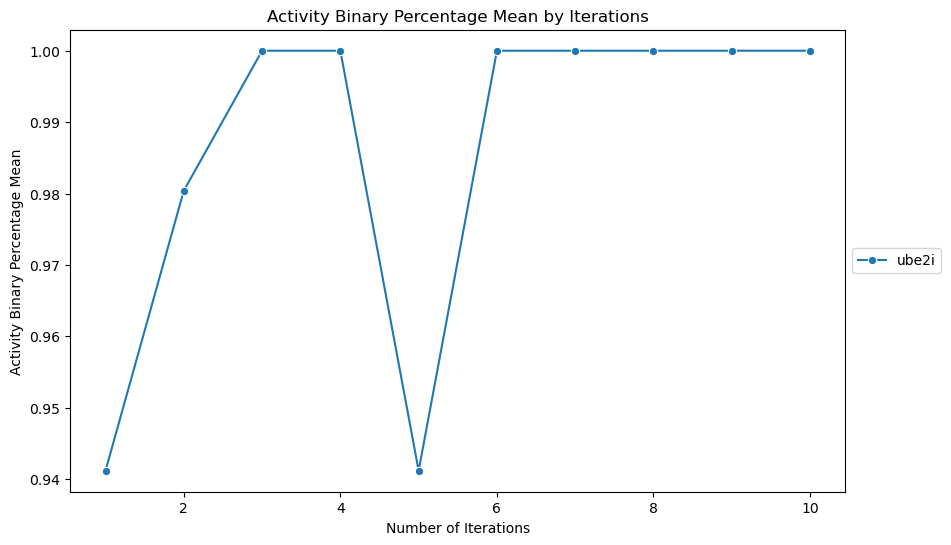

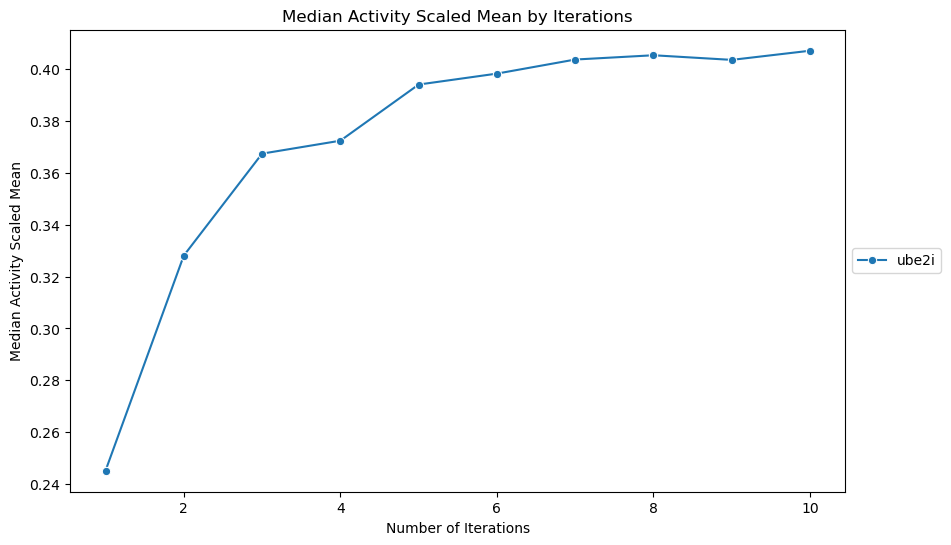

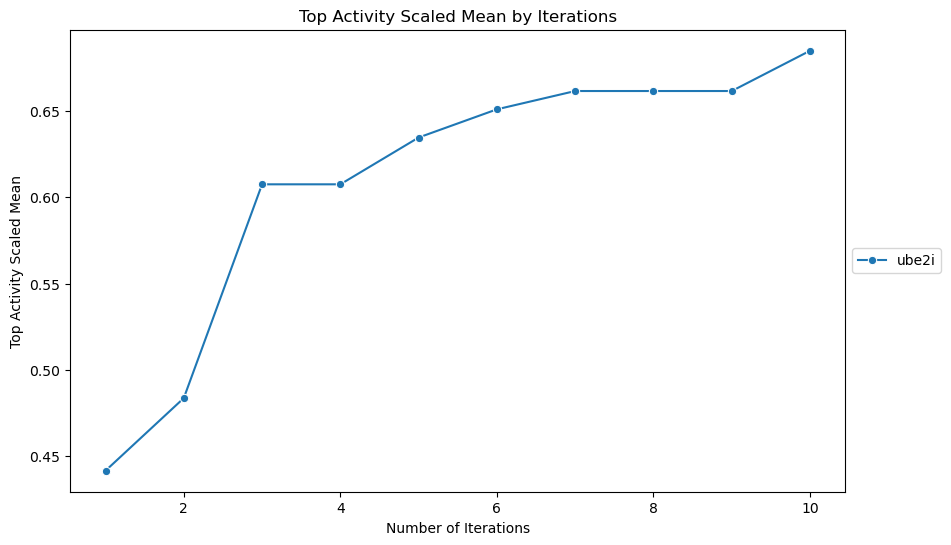

In [20]:
import pandas as pd
import os
from evolvepro.src.plot import (
    read_dms_data,
    filter_dataframe,
    plot_by_round,
    save_dataframe
)

base_dir = "."
data_dir = os.path.join(base_dir, "output/dms_results_ube2i")
output_dir = os.path.join(base_dir, "output/dms_plots_ube2i")

df = read_dms_data(
    directory=data_dir,
    datasets=["ube2i"],
    model="esm2_t36_3B_UR50D",
    experiment="esm2_3B_optimal",
    group_columns=["num_mutants_per_round","round_num"],
    aggregate_columns=["median_activity_scaled","top_activity_scaled","activity_binary_percentage"]
)

save_dataframe(df, output_dir=output_dir, output_file="markin_raw.csv")

plot_by_round(
    df,
    variable="activity_binary_percentage_mean",
    output_dir=output_dir,
    output_file="markin_activity_binary"
)

plot_by_round(
    df,
    variable="median_activity_scaled_mean",
    output_dir=output_dir,
    output_file="markin_median_activity"
)

plot_by_round(
    df,
    variable="top_activity_scaled_mean",
    output_dir=output_dir,
    output_file="markin_top_activity"
)
